<a href="https://colab.research.google.com/github/unipd-human-data/env-soundnet/blob/main/delta_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing

Installazione librerie e setup ambiente

In [ ]:
!pip install librosa pydub torchaudio snntorch tqdm matplotlib seaborn torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# Libreria standard
import os                               # file e cartelle
import numpy as np                      # operazioni matriciali, audio e spet sono matrici
import pandas as pd                     # leggere e gestire tabelle come esc50.csv
import matplotlib.pyplot as plt         # grafici std
import seaborn as sns                   # grafici statistici più belli

# Audio
import librosa                          # per audio in python, calcola features ecc
import librosa.display                  # visualizzare spettrogrammi
import torchaudio                       # audio di pytorch, usata per pipeline integrata con PyTorch
import torchaudio.transforms as T       # Moduli per convertire audio in MelSpectogram o trasfromazioni
from pydub import AudioSegment          # gestire audio a livello più "umano"

# Deep learning e SNN
import torch                            # costruzioni reti neurali
import snntorch as snn                  # estensione pytorch per SNN
import snntorch.functional as SF
from snntorch import spikegen           # converte input in spike train
from snntorch import spikeplot as splt
import tensorflow as tf                 # costruzione e training di modelli di ml e dl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from torchinfo import summary

# Altri
from tqdm import tqdm                   # aggiungere barre di progresso ai loop, quanto manca al caricamento audio
from torch.utils.data import Dataset    # Dataset class
from torch.utils.data import DataLoader # DataLoader class
from enum import Enum
import time
import itertools
import json

In [ ]:
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Userai:", device)

GPU disponibile: []
Userai: cpu


Collegamento al drive

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Uploading CSV of ESC-50 metadata. Relocation of audio files in the ESC-50 and ESC-10 folders

In [ ]:
esc_50_df = pd.read_csv("/content/drive/MyDrive/HumanData/ESC-50-master/meta/esc50.csv")

def relocate_files(file_name, category, is_esc10):
  src = f"/content/drive/MyDrive/HumanData/ESC-50-master/audio/{file_name}"
  esc50_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-50/{category}"
  esc10_dest_folder = f"/content/drive/MyDrive/HumanData/ESC-10/{category}"

  # Ensure destination folder exists, creation folders
  os.makedirs(esc50_dest_folder, exist_ok=True)
  if is_esc10:
    os.makedirs(esc10_dest_folder, exist_ok=True)

  dest_esc50 = os.path.join(esc50_dest_folder, file_name)
  dest_esc10 = os.path.join(esc10_dest_folder, file_name)

  # Check if the file already exists in the destination
  if not os.path.exists(dest_esc50):
    shutil.copy(src, dest_esc50)
    print(f"Moved {file_name} to {dest_esc50}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc50}', skipping...")

  if not os.path.exists(dest_esc10):
    if is_esc10:
      shutil.copy(src, dest_esc10)
      print(f"Moved {file_name} to {dest_esc10}")
  else:
    print(f"File '{file_name}' already exists in '{dest_esc10}', skipping...")


#esc_50_df.apply(lambda row: relocate_files(row['filename'], row['category'], row['esc10']), axis = 1)


In [ ]:
%ls /content/drive/MyDrive/HumanData/ESC-10/


chainsaw/    crackling_fire/  dog/         rain/     sea_waves/
clock_tick/  crying_baby/     helicopter/  rooster/  sneezing/


## Processare tutti i file audio di ESC10

In [ ]:
BASE_PATH = '/content/drive/MyDrive/HumanData/ESC-10'
SAMPLE_RATE = 44100  # non fare downsampling
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 512
DURATION = 5.0       # lunghezza standard (secondi)
BATCH_SIZE = 32

class ESCLabels(Enum):
    chainsaw = 0
    clock_tick = 1
    crackling_fire = 2
    crying_baby = 3
    dog = 4
    helicopter = 5
    rain = 6
    rooster = 7
    sea_waves = 8
    sneezing = 9

- Se un audio ha una frequenza di campionamento di 44.1 kHz, significa che ogni secondo è rappresentato da 44.100 campioni (numeri). Più alta è la frequenza, più dettagliato sarà il suono (fino a un certo limite). 44.1 kHz è sufficiente per rappresentare tutte le frequenze udibili dall’orecchio umano (fino a ~20 kHz), secondo il teorema di Nyquist.

- Trim + Normalizzazione: rimuovo silenzio per non sprecare tempo computazionale su dati inutili. Scalare il segnale in [-1,1] in modo da rimuovere il bias di ampiezza tra clip (evita che la rete impari "volume=classe")

- Con la normalizzazione vado a modificare il range dell'ampiezza, cioè quanto forte o debole è il segnale

per ora non trimmo i silenzio --> possibile ablation study con e senza trim

Perché NON usare trim:
Mantieni la coerenza temporale tra le clip
→ fondamentale per SNN e spike encoding, che sono sensibili alla sequenza temporale dei pattern.

Eviti disallineamenti introdotti da librosa.effects.trim
→ anche 0.2 secondi di shift possono alterare l’input percepito dal modello.

Se usi segmenti (chunk) fissi via timesteps=50,
→ i segmenti devono sempre partire dallo stesso punto temporale.

In [ ]:
def load_audio_file(file_path, sr=SAMPLE_RATE, duration=5.0, top_db = 30):
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    #y, _ = librosa.effects.trim(y, top_db=top_db)           # elimina silence iniziale e finale
    y = librosa.util.normalize(y)           # normalizzazione RMS
    #if len(y) < int(sr * duration):
    #    padding = int(sr * duration) - len(y)
    #    y = np.pad(y, (0, padding))         # padding se troppo corto
    return y

controllo di quanto silenzio toglie

In [ ]:
# total_trimmed_start = 0.0
# total_trimmed_end = 0.0
# clip_count = 0

# for label in sorted(os.listdir(BASE_PATH)):
#     class_path = os.path.join(BASE_PATH, label)
#     for file in os.listdir(class_path):
#         if file.endswith(".wav"):
#             file_path = os.path.join(class_path, file)

#             # Carica audio
#             y, sr = librosa.load(file_path, sr=44100, duration=5.0)

#             # Applica trim
#             y_trimmed, index = librosa.effects.trim(y, top_db=30)
#             start_sample, end_sample = index

#             # Converti in secondi
#             start_sec = start_sample / sr
#             end_sec = (len(y) - end_sample) / sr

#             total_trimmed_start += start_sec
#             total_trimmed_end += end_sec
#             clip_count += 1

#             print(f"{file} → Trim: start={start_sec:.2f}s, end={end_sec:.2f}s")

# # Statistiche finali
# print("\n--- STATISTICHE TOTALI ---")
# print(f"Clip analizzati: {clip_count}")
# print(f"Silenzio medio INIZIALE tagliato: {total_trimmed_start / clip_count:.2f} s")
# print(f"Silenzio medio FINALE tagliato: {total_trimmed_end / clip_count:.2f} s")


In [ ]:
X_audio = []
y_labels = []
labels = sorted(os.listdir(BASE_PATH))  # lista classi ordinate
print(labels, "\n")
label_to_index = {label: idx for idx, label in enumerate(labels)}

for label in tqdm(labels, desc="Caricamento Audio"):
    class_path = os.path.join(BASE_PATH, label)
    for file in os.listdir(class_path):
        if file.endswith('.wav'):
            file_path = os.path.join(class_path, file)
            y = load_audio_file(file_path, sr=SAMPLE_RATE, duration=DURATION)
            X_audio.append(y)
            y_labels.append(label_to_index[label])

['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog', 'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'] 



Caricamento Audio: 100%|██████████| 10/10 [02:11<00:00, 13.19s/it]


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X_audio, y_labels, test_size=0.3, random_state=42, stratify=y_labels)

# Poi dividi temp in val e test (50/50 => 15% ciascuno)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 280, Val: 60, Test: 60


## NAA

In [ ]:
"""
def center_crop(signal, target_len):
    if len(signal) < target_len:
        pad_left = (target_len - len(signal)) // 2
        pad_right = target_len - len(signal) - pad_left
        return np.pad(signal, (pad_left, pad_right), mode='constant')
    else:
        start = (len(signal) - target_len) // 2
        return signal[start:start + target_len]
"""

"\ndef center_crop(signal, target_len):\n    if len(signal) < target_len:\n        pad_left = (target_len - len(signal)) // 2\n        pad_right = target_len - len(signal) - pad_left\n        return np.pad(signal, (pad_left, pad_right), mode='constant')\n    else:\n        start = (len(signal) - target_len) // 2\n        return signal[start:start + target_len]\n"

In [ ]:
"""
def naa(y, sr):
    augmented = []
    target_len = int(sr * 5.0)

    # Originale
    augmented.append(center_crop(y, target_len))

    # Pitch shift
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2), target_len))
    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2), target_len))

    # Time stretch
    for rate in [0.7, 1.2]:
        y_stretched = librosa.effects.time_stretch(y, rate=rate)
        augmented.append(center_crop(y_stretched, target_len))

    return augmented
"""

'\ndef naa(y, sr):\n    augmented = []\n    target_len = int(sr * 5.0)\n\n    # Originale\n    augmented.append(center_crop(y, target_len))\n\n    # Pitch shift\n    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=+2), target_len))\n    augmented.append(center_crop(librosa.effects.pitch_shift(y, sr=sr, n_steps=-2), target_len))\n\n    # Time stretch\n    for rate in [0.7, 1.2]:\n        y_stretched = librosa.effects.time_stretch(y, rate=rate)\n        augmented.append(center_crop(y_stretched, target_len))\n\n    return augmented\n'

In [ ]:
"""
X_train_aug = []
y_train_aug = []

for i in tqdm(range(len(X_train)), desc="NAA"):
    original_audio = X_train[i]
    label = y_train[i]

    # Applica la tua funzione naa → restituisce 5 versioni (incluso l'originale)
    augmented_audios = naa(original_audio, sr=SAMPLE_RATE)

    # Aggiungi tutte le versioni alla lista finale
    X_train_aug.extend(augmented_audios)
    y_train_aug.extend([label] * len(augmented_audios))
"""

'\nX_train_aug = []\ny_train_aug = []\n\nfor i in tqdm(range(len(X_train)), desc="NAA"):\n    original_audio = X_train[i]\n    label = y_train[i]\n\n    # Applica la tua funzione naa → restituisce 5 versioni (incluso l\'originale)\n    augmented_audios = naa(original_audio, sr=SAMPLE_RATE)\n\n    # Aggiungi tutte le versioni alla lista finale\n    X_train_aug.extend(augmented_audios)\n    y_train_aug.extend([label] * len(augmented_audios))\n'

In [ ]:
"""
# Calcola le lunghezze di tutti gli audio
lengths = [len(x) for x in X_train_aug]

# Trova il minimo e il massimo
min_len = min(lengths)
max_len = max(lengths)

# Converti in secondi (facoltativo)
min_sec = min_len / SAMPLE_RATE
max_sec = max_len / SAMPLE_RATE

print(f"Audio più corto: {min_len} samples ({min_sec:.2f} s)")
print(f"Audio più lungo: {max_len} samples ({max_sec:.2f} s)")

"""


'\n# Calcola le lunghezze di tutti gli audio\nlengths = [len(x) for x in X_train_aug]\n\n# Trova il minimo e il massimo\nmin_len = min(lengths)\nmax_len = max(lengths)\n\n# Converti in secondi (facoltativo)\nmin_sec = min_len / SAMPLE_RATE\nmax_sec = max_len / SAMPLE_RATE\n\nprint(f"Audio più corto: {min_len} samples ({min_sec:.2f} s)")\nprint(f"Audio più lungo: {max_len} samples ({max_sec:.2f} s)")\n\n'

## Converti in log-Mel

- power_to_db(..., ref=np.max) normalizza ogni spettrogramma rispetto al suo massimo → rende il contrasto tra le bande più utile per la rete. Misura quanto ogni frequenza è forte rispetto al picco. Ha senso np.max perchè ho già normalizzato l'audio a [-1,1] quindi non hai una loudness assoluta. Per la classificazione di suoni ambientali il pattern spettrale è più importante del volume, voglio che ogni clip sia trattato in modo coerente (garantisce scale relative)

- power_to_db(..., ref=np.max) converte il Mel-spectrogramma da potenza lineare (espressa in unità numeriche) a decibel (scala logaritmica)

- il risultato più intenso avrà valore 0 dB. -80 invece significa “tutto ciò che è almeno 10⁸ volte più debole del valore massimo, consideralo praticamente silenzio”. La scala è negativa perchè stai calcolando il logaritmo del rapporto tra ogni valore del Mel-spect e il valore massimo di quel mel-spect



In [ ]:
def preprocess_audio(y, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
  #Calcolare Mel-spectrogram
  y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
  #Convertire in Log
  y_mel = librosa.power_to_db(y_mel, ref=np.max)    #calcola i db rispetto al valore massimo nel Mel-spect.

  return y_mel


Clipping dei frame troppo silenziosi

In [ ]:
"""
def clip_silent_frames(mel, threshold_db=-70.0):
    silent_mask = np.all(mel < threshold_db, axis=0)
    mel[:, silent_mask] = threshold_db  # o np.mean(mel)
    return mel
"""

'\ndef clip_silent_frames(mel, threshold_db=-70.0):\n    silent_mask = np.all(mel < threshold_db, axis=0)\n    mel[:, silent_mask] = threshold_db  # o np.mean(mel)\n    return mel\n'

In [ ]:
def batch_logmel(X, sr=SAMPLE_RATE):
    mel_list = []
    for x in tqdm(X, desc="Log-Mel"):
        mel = preprocess_audio(x, sr=sr)
        # mel = clip_silent_frames(mel)
        mel_list.append(mel)
    return mel_list

In [ ]:
"""
X_train_mel = batch_logmel(X_train_aug)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)
"""

X_train_mel = batch_logmel(X_train)
X_val_mel = batch_logmel(X_val)
X_test_mel = batch_logmel(X_test)

Log-Mel: 100%|██████████| 60/60 [00:01<00:00, 59.97it/s]


In [ ]:
print("Train set:", len(X_train_mel))
print("Val set:", len(X_val_mel))
print("Test set:", len(X_test_mel))

print("Shape primo sample train:", X_train_mel[0].shape)

Train set: 280
Val set: 60
Test set: 60
Shape primo sample train: (128, 431)


visualizzo logmel spect

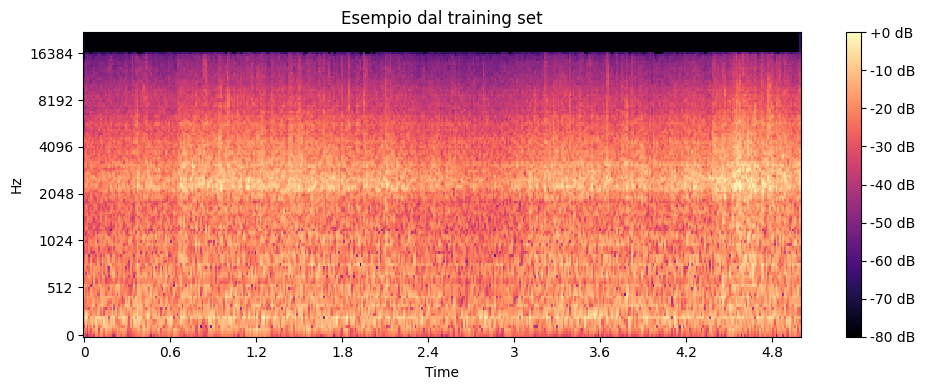

Class:  rain


In [ ]:
def show_mel(mel, title="Log-Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualizza un esempio a caso dal training set
sample_idx = 32
show_mel(X_train_mel[sample_idx], title="Esempio dal training set")
print("Class: ", ESCLabels(y_train[sample_idx]).name)


In [ ]:
all_vals = np.concatenate([mel.flatten() for mel in X_train_mel])
print("Min:", np.min(all_vals))
print("Max:", np.max(all_vals))

Min: -80.0
Max: 0.0


Padding per uniformare a 450

In [ ]:
"""
def pad_to_multiple_of(mel, multiple=50, value=-80.0):
    Pads mel spectrogram along time axis to make time frames a multiple of 'multiple'
    current_len = mel.shape[1]
    target_len = ((current_len + multiple - 1) // multiple) * multiple
    pad_width = target_len - current_len
    return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=value)
"""


"\ndef pad_to_multiple_of(mel, multiple=50, value=-80.0):\n    Pads mel spectrogram along time axis to make time frames a multiple of 'multiple'\n    current_len = mel.shape[1]\n    target_len = ((current_len + multiple - 1) // multiple) * multiple\n    pad_width = target_len - current_len\n    return np.pad(mel, ((0, 0), (0, pad_width)), mode='constant', constant_values=value)\n"

In [ ]:
"""
# Applica padding a multiplo di 50 (compatibile con timesteps=50)
X_train_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_train_mel]
X_val_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_val_mel]
X_test_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_test_mel]
"""

'\n# Applica padding a multiplo di 50 (compatibile con timesteps=50)\nX_train_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_train_mel]\nX_val_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_val_mel]\nX_test_mel = [pad_to_multiple_of(mel, multiple=50) for mel in X_test_mel]\n'

In [ ]:
print("Train shape esempio:", X_train_mel[0].shape)
print("Val shape esempio:", X_val_mel[0].shape)
print("Test shape esempio:", X_test_mel[0].shape)

Train shape esempio: (128, 431)
Val shape esempio: (128, 431)
Test shape esempio: (128, 431)


## DATA AUG TAA

applicare taa dopo normalizzazione perchè imagedatagenerator lavora bene su [0,1]

In [ ]:
"""
taa_generator = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.3,
    fill_mode='nearest'
)
"""

"\ntaa_generator = ImageDataGenerator(\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    zoom_range=0.25,\n    shear_range=0.3,\n    fill_mode='nearest'\n)\n"

In [ ]:
X_train_mel_np = np.array(X_train_mel)
X_val_mel_np = np.array(X_val_mel)
X_test_mel_np = np.array(X_test_mel)

if len(X_train_mel_np.shape) == 3:
    X_train_mel_np = X_train_mel_np[..., np.newaxis]  # (N, 64, 431, 1)

#y_train_np = np.array(y_train_aug)  # Etichette corrispondenti
y_train_np = np.array(y_train)

### Normalizzazione:
i modelli funzionano meglio con input compresi tra 0 e 1.
0 = silenzio
1 = banda più forte

In [ ]:
X_train_mel_np = (X_train_mel_np + 80.0) / 80.0
X_val_mel_np = (X_val_mel_np + 80.0) / 80.0
X_test_mel_np = (X_test_mel_np + 80.0) / 80.0

### TAA

In [ ]:
"""
X_taa = []
y_taa = []

augmentations_per_sample = 4  # puoi aumentare questo numero

for i in tqdm(range(len(X_train_mel_np)), desc="TAA Augmentation"):
    sample = X_train_mel_np[i]  # shape: (64, max_len, 1)
    sample = np.expand_dims(sample, axis=0)  # shape: (1, 64, max_len, 1)

    # Genera augmentazioni
    gen = taa_generator.flow(sample, batch_size=1)
    for _ in range(augmentations_per_sample):
        aug_sample = next(gen)[0]  # shape: (64, max_len, 1)
        X_taa.append(aug_sample)
        y_taa.append(y_train_np[i])

# Combina con il training set originale
X_train_augmented = np.concatenate([X_train_mel_np, np.array(X_taa)], axis=0)
y_train_augmented = np.concatenate([y_train_np, np.array(y_taa)], axis=0)

print("Nuova shape X:", X_train_augmented.shape)
print("Nuova shape y:", y_train_augmented.shape)
"""

'\nX_taa = []\ny_taa = []\n\naugmentations_per_sample = 4  # puoi aumentare questo numero\n\nfor i in tqdm(range(len(X_train_mel_np)), desc="TAA Augmentation"):\n    sample = X_train_mel_np[i]  # shape: (64, max_len, 1)\n    sample = np.expand_dims(sample, axis=0)  # shape: (1, 64, max_len, 1)\n\n    # Genera augmentazioni\n    gen = taa_generator.flow(sample, batch_size=1)\n    for _ in range(augmentations_per_sample):\n        aug_sample = next(gen)[0]  # shape: (64, max_len, 1)\n        X_taa.append(aug_sample)\n        y_taa.append(y_train_np[i])\n\n# Combina con il training set originale\nX_train_augmented = np.concatenate([X_train_mel_np, np.array(X_taa)], axis=0)\ny_train_augmented = np.concatenate([y_train_np, np.array(y_taa)], axis=0)\n\nprint("Nuova shape X:", X_train_augmented.shape)\nprint("Nuova shape y:", y_train_augmented.shape)\n'

Converto in tensori

In [ ]:
"""
X_train = torch.from_numpy(X_train_augmented).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_augmented).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()
"""

X_train = torch.from_numpy(X_train_mel_np).float()
X_val = torch.from_numpy(X_val_mel_np).float()
X_test = torch.from_numpy(X_test_mel_np).float()
y_train = torch.from_numpy(y_train_np).long()
y_val = torch.from_numpy(np.array(y_val)).long()
y_test = torch.from_numpy(np.array(y_test)).long()

In [ ]:
print("Shape X_train:", X_train.shape)
print("Tipo dati:", X_train.dtype)
print("Valori min/max:", torch.min(X_train), torch.max(X_train))


Shape X_train: torch.Size([280, 128, 431, 1])
Tipo dati: torch.float32
Valori min/max: tensor(0.) tensor(1.)


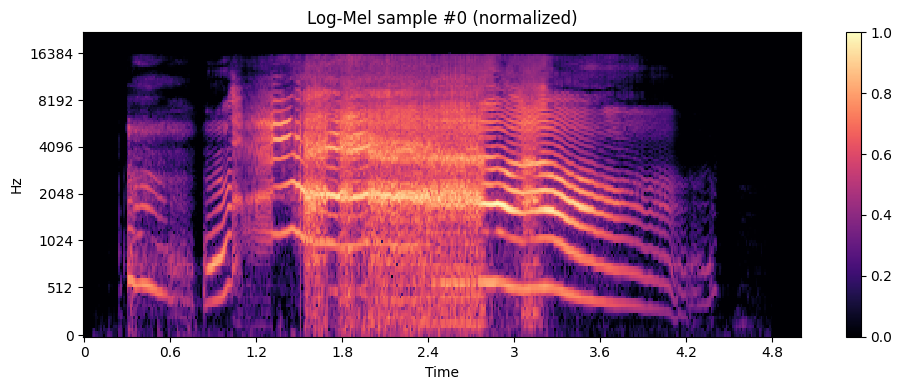

Class: crying_baby


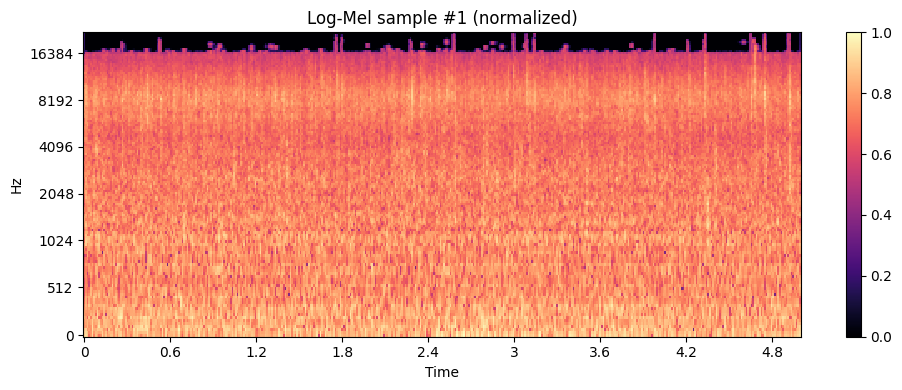

Class: rain


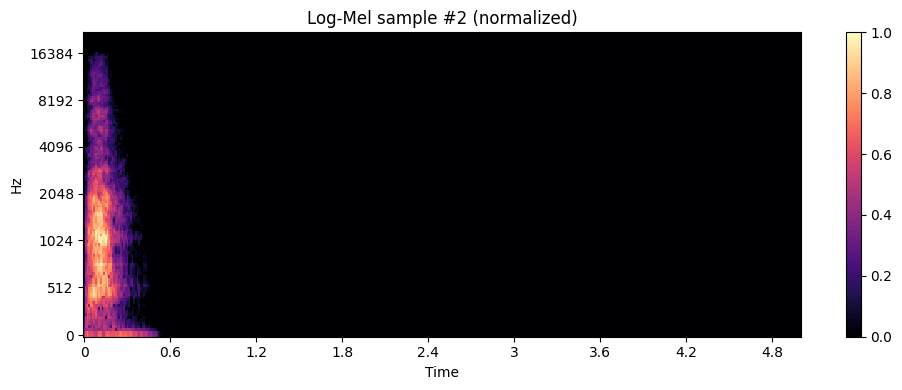

Class: dog


In [ ]:
def show_mel_sample(index):
    mel = X_train[index].numpy().squeeze()  # converti tensore in NumPy
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
    plt.colorbar()  # non usare '%+2.0f dB' perché ora i valori sono [0, 1]
    plt.title(f"Log-Mel sample #{index} (normalized)")
    plt.tight_layout()
    plt.show()
    print("Class:", ESCLabels(y_train[index].item()).name)

for i in range(3):
    show_mel_sample(i)

In [ ]:
print("y_train shape:", y_train.shape)
print("Etichette uniche:", np.unique(y_train))

# Stampa etichetta di un esempio
for i in range(3):
    print(f"Esempio {i}: label = {y_train[i]}")


y_train shape: torch.Size([280])
Etichette uniche: [0 1 2 3 4 5 6 7 8 9]
Esempio 0: label = 3
Esempio 1: label = 6
Esempio 2: label = 4


# Spike Encoding

We define now an helper function to visualize the following ecoded spike trains.

In [ ]:
def visualize_spike_trains(spike_tensor, sample_idx=0, mel_bin=10):
    """
    Visualizes delta spike encodings with three plots:
    1. Full raster plot of all mel bins
    2. Single mel bin spike train with vertical lines
    3. Density plot showing balance between positive and negative spikes

    Args:
      spike_tensor : torch.Tensor or list
          The delta spike tensor. Expected shape: [batch_size, time_frames, n_mels]
          If from DataLoader, expected to be a list containing tensors
      sample_idx : int
          Index of the sample in the batch to visualize
      mel_bin : int
          Which mel frequency bin to visualize in the spike train plot
    """

    # Check if input is a list (from DataLoader) or direct tensor
    if isinstance(spike_tensor, list):
        spikes = spike_tensor[0].squeeze(-1)[sample_idx].detach().cpu().numpy()
    elif isinstance(spike_tensor, torch.Tensor):
        # If 4D tensor [batch_size, time_frames, n_mels]
        if len(spike_tensor.shape) == 3:
            spikes = spike_tensor.squeeze(-1)[sample_idx, :, :].detach().cpu().numpy()
        else:
            raise ValueError(f"Unexpected spike tensor shape: {spike_tensor.shape}")
    else:
        raise TypeError("spike_tensor must be a torch.Tensor or a list containing tensors")

    if len(spikes.shape) > 2:
        spikes = spikes.squeeze()

    pos_spikes = (spikes > 0).astype(float)
    neg_spikes = (spikes < 0).astype(float)

    plt.figure(figsize=(10, 12))

    # 1. Raster Plot with Inverted Y-axis
    plt.subplot(3, 1, 1)
    plt.imshow(spikes.T, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1, origin='lower')
    plt.colorbar(ticks=[-1, 0, 1], label='Spike Type')
    plt.title("Full Raster Plot")
    plt.xlabel("Time Step")
    plt.ylabel("Mel Bin")
    num_mel_bins = spikes.shape[1]
    tick_interval = max(1, num_mel_bins // 7)
    plt.yticks(np.arange(0, num_mel_bins, tick_interval))

    # 2. Single Mel Bin Spike Train with vlines
    plt.subplot(3, 1, 2)
    pos_times = np.where(spikes[:, mel_bin] == 1)[0]
    neg_times = np.where(spikes[:, mel_bin] == -1)[0]
    plt.vlines(pos_times, 0, 1, color='red', linewidth=0.8)
    plt.vlines(neg_times, -1, 0, color='blue', linewidth=0.8)
    plt.yticks([-1, 0, 1])
    plt.ylim(-1.2, 1.2)
    plt.title(f"Spike Train for Mel Bin {mel_bin}")
    plt.xlabel("Time Step")
    plt.ylabel("Spike Value")
    plt.grid(False)
    legend_elements = [plt.Line2D([0], [0], color='red', lw=2, label='Positive Spikes'),
                      plt.Line2D([0], [0], color='blue', lw=2, label='Negative Spikes')]
    plt.legend(handles=legend_elements)

    # 3. Density Plot with Legend
    plt.subplot(3, 1, 3)
    plt.stackplot(np.arange(spikes.shape[0]),
                  pos_spikes.sum(axis=1),
                  -neg_spikes.sum(axis=1),
                  colors=['red', 'blue'])

    plt.legend(['Positive Spikes', 'Negative Spikes'])
    plt.title("Spike Polarity Balance Over Time")
    plt.xlabel("Time Step")
    plt.ylabel("Net Spike Count")

    plt.tight_layout()
    plt.show()

## Delta Modulation

Delta modulation converts time-series tensors into spike trains by looking at the difference between pair of subsequent values.

By default, if the difference is both *positive* and *greater than a predefined threshold* $V_{\text{thr}}$, a spike is generated.
However, this type of encoding does not account for large negative peaks in the signal, leading to a possible loss of information in the encoding. For this reason, we consider also negative spikes (or *off-spikes*), that are generated when the difference between subsequent values is both *negative* and *greater than the threshold* $V_{\text{thr}}$ *in absolute value*.

Mathematically, given an input sequence $x[t], t=1,\dots,T$, where $T$ denotes the number of time steps, and a *positive* threshold $V_{\text{thr}}$, the spike encoding with delta modulation is obtained as:
$$
S[t] =
\begin{cases}
\, 1 \qquad \text{if}\;\; x[t+1]-x[t] > V_{\text{thr}}\\
-1 \;\,\quad \text{if}\;\; x[t+1]-x[t] < -V_{\text{thr}}\\
\, 0 \qquad \text{otherwise.}
\end{cases}
$$



Due to the high dimensionality of the input data, feeding it directly into the model significantly slows down training. To mitigate this, I implemented an aggregation process within the \_\_getitem\_\_() function. This process divides the spectrogram along the time axis into fixed-size chunks and computes the mean across the time frames within each chunk, effectively reducing the temporal resolution and improving training efficiency.



In [ ]:
class DeltaAudioDataset(Dataset):
    def __init__(self, X, y, threshold=0.05, timesteps=10, off_spike=True):
        """
        X: Tensor of shape [num_samples, n_mels, time_steps, 1]
        y: Tensor of shape [num_samples]
        """
        self.X = X
        self.y = y
        self.timesteps = timesteps
        self.threshold = threshold
        self.off_spike = off_spike

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].squeeze(-1)  # [n_mels, time_steps]
        y = self.y[idx]

        chunks = torch.tensor_split(x, self.timesteps, dim=-1)

        x_chunks = torch.stack(
            [window.mean(dim=-1) for window in chunks], dim=0
        )

        # Apply delta modulation (shape stays [time_steps, n_mels])
        spike_train = spikegen.delta(
            x_chunks, threshold=self.threshold, off_spike=self.off_spike
        )

        return spike_train, y.long()

In [ ]:
# Datasets
train_dataset = DeltaAudioDataset(
    X_train,
    y_train,
    threshold=0.08,
    timesteps=431
)
val_dataset = DeltaAudioDataset(
    X_val,
    y_val,
    threshold=0.08,
    timesteps=431
)
test_dataset = DeltaAudioDataset(
    X_test,
    y_test,
    threshold=0.08,
    timesteps=431
)

# Data Loaders
delta_train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)
delta_val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)
delta_test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers = 2,
    pin_memory=torch.cuda.is_available()
)

X_batch, y_batch = next(iter(delta_train_dataloader))
print("DeltaModulation encoding compleated!")

DeltaModulation encoding compleated!


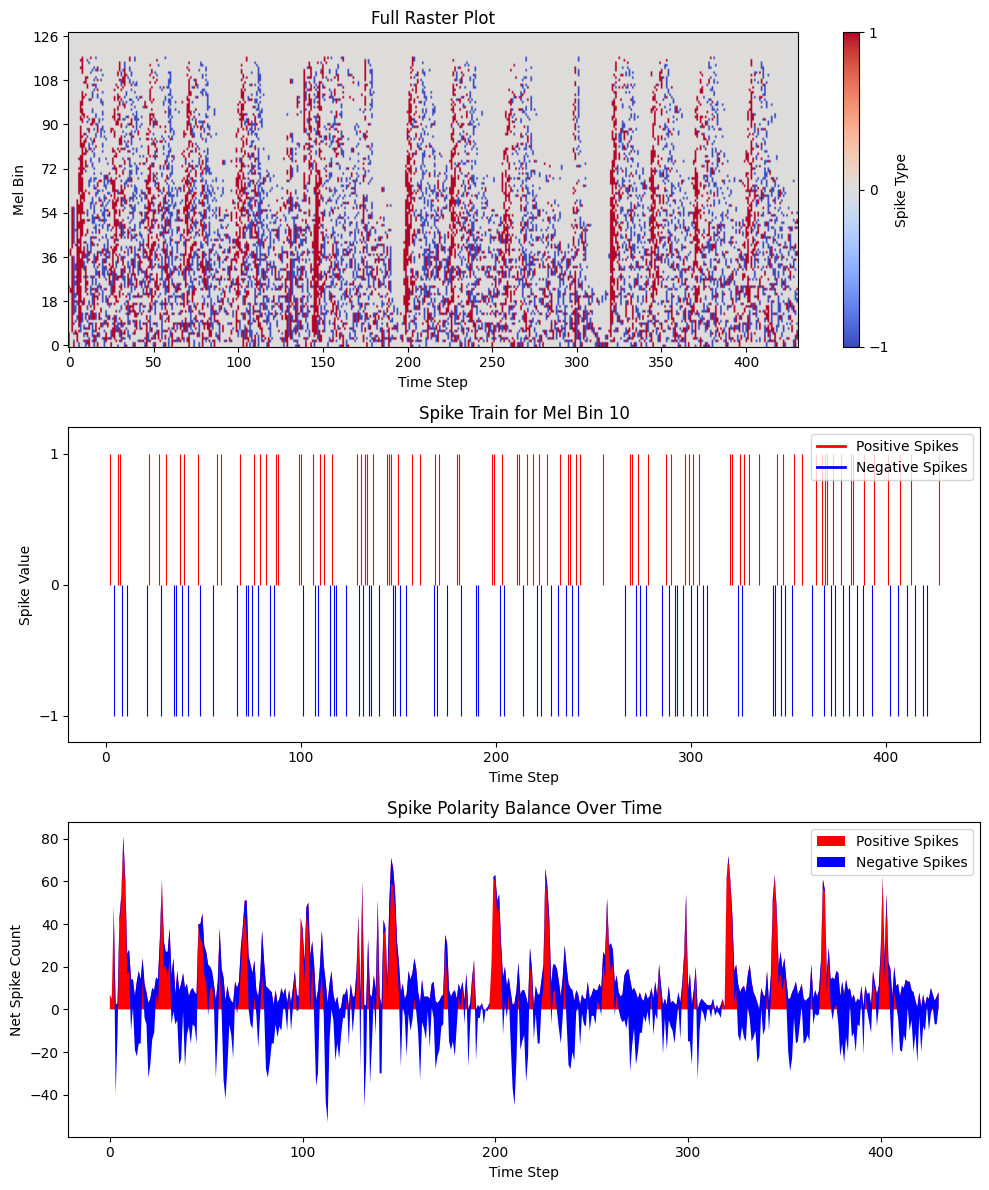

Class dog


In [ ]:
sample_idx = 2
visualize_spike_trains(X_batch, sample_idx=sample_idx, mel_bin=10)
print("Class", ESCLabels(y_batch[sample_idx].item()).name)

Identificazione dei frame silenziosi nei log-mel

In [ ]:
def count_silent_frames(mel_list, silence_threshold_db=-70):
    silent_frame_counts = []
    for mel in tqdm(mel_list, desc="Analisi dei frame silenziosi"):
        # Conta i frame in cui tutti i valori sono inferiori alla soglia di silenzio
        silent_frames = np.all(mel < silence_threshold_db, axis=0)
        silent_frame_counts.append(np.sum(silent_frames))
    return silent_frame_counts

In [ ]:
silent_counts_train = count_silent_frames(X_train_mel)
silent_counts_val = count_silent_frames(X_val_mel)
silent_counts_test = count_silent_frames(X_test_mel)

print(f"\nMedia dei frame silenziosi nel training set: {np.mean(silent_counts_train):.2f}")
print(f"Media dei frame silenziosi nel validation set: {np.mean(silent_counts_val):.2f}")
print(f"Media dei frame silenziosi nel test set: {np.mean(silent_counts_test):.2f}")


Analisi dei frame silenziosi: 100%|██████████| 60/60 [00:00<00:00, 8044.83it/s]


Media dei frame silenziosi nel training set: 55.86
Media dei frame silenziosi nel validation set: 43.88
Media dei frame silenziosi nel test set: 60.07


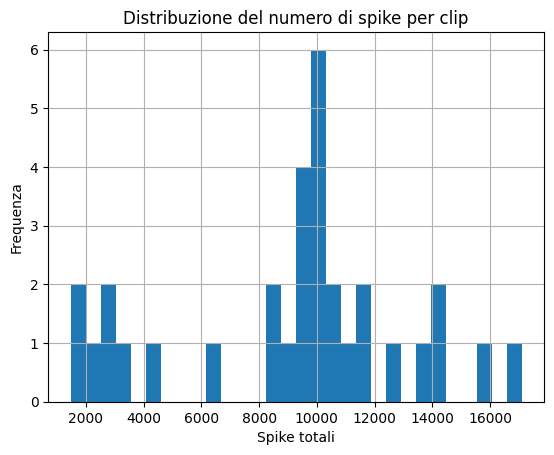

Spike rate medio per clip: 9193.53


In [ ]:
def count_spikes(spike_train):
    return spike_train.abs().sum(dim=[1, 2])  # somma spike su tempo e bande mel

spike_counts = count_spikes(X_batch)
plt.hist(spike_counts.cpu().numpy(), bins=30)
plt.title("Distribuzione del numero di spike per clip")
plt.xlabel("Spike totali")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()

avg_spike_rate = spike_counts.float().mean().item()
print(f"Spike rate medio per clip: {avg_spike_rate:.2f}")


# SNN Modelling

A single batch of data has shape: \[batch_size, time_frames, n_mels\].

In [ ]:
class SNNClassifier(torch.nn.Module):
    def __init__(
        self,
        n_mels,
        hidden_sizes,
        num_classes,
        surr_grad,
        learn_thr=True,
        learn_beta=True,
    ):
        super(SNNClassifier, self).__init__()
        self.n_mels = n_mels
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # Layer 1: Input to Hidden 1
        self.fc1 = torch.nn.Linear(n_mels, self.hidden_sizes[0])
        self.lif1 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[0],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 2: Hidden 1 to Hidden 2
        self.fc2 = torch.nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1])
        self.lif2 = snn.Leaky(
            beta=torch.full((self.hidden_sizes[1],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 3: Hidden 2 to Hidden 3
        #self.fc3 = torch.nn.Linear(self.hidden_sizes[1], self.hidden_sizes[2])
        #self.lif3 = snn.Leaky(
            #beta=torch.full((self.hidden_sizes[2],), 0.5),
            #learn_beta=learn_beta,
            #learn_threshold=learn_thr,
            #spike_grad=surr_grad,
            #reset_mechanism="zero",
        #)

        # Output Layer
        self.fc_out = torch.nn.Linear(self.hidden_sizes[1], num_classes)
        self.lif_out = snn.Leaky(
            beta=torch.full((num_classes,), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism='none',
        )

    def forward(self, x):
        batch_size, time_steps, _ = x.shape

        # Initialize membrane potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        #mem3 = self.lif3.init_leaky()
        mem_out = self.lif_out.init_leaky()

        spk_rec = []
        mem_rec = []

        for step in range(time_steps):
            x_t = x[:, step, :]

            cur1 = self.fc1(x_t)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            # cur3 = self.fc3(spk2)
            # spk3, mem3 = self.lif3(cur3, mem3)

            cur_out = self.fc_out(spk2)
            spk_out, mem_out = self.lif_out(cur_out, mem_out)

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)


### dropout

In [ ]:
class SNNClassifier(torch.nn.Module):
    def __init__(
        self,
        n_mels,
        hidden_sizes,
        num_classes,
        surr_grad,
        learn_thr=True,
        learn_beta=True,
        dropout=0.0,  # nuovo parametro
    ):
        super(SNNClassifier, self).__init__()
        self.n_mels = n_mels
        self.hidden_sizes = hidden_sizes
        self.num_classes = num_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta
        self.dropout = dropout

        # Layer 1: Input to Hidden 1
        self.fc1 = torch.nn.Linear(n_mels, hidden_sizes[0])
        self.do1 = torch.nn.Dropout(p=dropout)
        self.lif1 = snn.Leaky(
            beta=torch.full((hidden_sizes[0],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Layer 2: Hidden 1 to Hidden 2
        self.fc2 = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.do2 = torch.nn.Dropout(p=dropout)
        self.lif2 = snn.Leaky(
            beta=torch.full((hidden_sizes[1],), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism="zero",
        )

        # Output Layer
        self.fc_out = torch.nn.Linear(hidden_sizes[1], num_classes)
        self.lif_out = snn.Leaky(
            beta=torch.full((num_classes,), 0.5),
            learn_beta=learn_beta,
            learn_threshold=learn_thr,
            spike_grad=surr_grad,
            reset_mechanism='none',
        )

    def forward(self, x):
        batch_size, time_steps, _ = x.shape

        # Init membrane potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_out = self.lif_out.init_leaky()

        spk_rec = []
        mem_rec = []

        for step in range(time_steps):
            x_t = x[:, step, :]

            cur1 = self.do1(self.fc1(x_t))
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.do2(self.fc2(spk1))
            spk2, mem2 = self.lif2(cur2, mem2)

            cur_out = self.fc_out(spk2)
            spk_out, mem_out = self.lif_out(cur_out, mem_out)

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)

### funzione di training

In [ ]:
def train_fn(model, train_loader, valid_loader, accuracy, loss_fn, optimizer,
             epochs, patience, path, verbose=True, max_batches=None):
    """
    Optimized training function with:
    - Mixed precision training
    - Reduced GPU memory usage
    - Progress tracking
    """
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    counter = 0
    best_val_loss = float('inf')

    # Enable mixed precision training if available
    scaler = torch.amp.GradScaler() if torch.cuda.is_available() else None

    for epoch in tqdm(range(epochs), desc="Epochs"):
        start_time = time.time()

        # Training mode
        model.train()
        train_loss, train_acc = 0.0, 0.0

        for batch_idx, (X, y) in enumerate(tqdm(train_loader, desc="Train batches", leave=False, total=len(train_loader))):
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            optimizer.zero_grad(set_to_none=True)

            # Use mixed precision where available
            if scaler:
                with torch.cuda.amp.autocast():
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                # Scale gradients and optimize
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                spk_out, _ = model(X.float())
                acc = accuracy(spk_out, y)
                loss = loss_fn(spk_out, y)
                loss.backward()
                optimizer.step()

            train_acc += acc.item()
            train_loss += loss.item()

            # Free up memory
            del X, y, spk_out, loss, acc

        # Calculate average metrics
        train_loss_avg = train_loss / len(train_loader)
        train_acc_avg = train_acc / len(train_loader)
        train_loss_list.append(train_loss_avg)
        train_acc_list.append(train_acc_avg)

        # Validation phase
        model.eval()
        val_loss, val_acc = 0.0, 0.0

        with torch.no_grad():
            for batch_idx, (X, y) in enumerate(valid_loader):
                X = X.squeeze().to(device)
                y = y.squeeze().long().to(device)

                # Forward pass with reduced memory usage
                if scaler:
                    with torch.cuda.amp.autocast():
                        spk_out, _ = model(X.float())
                        acc = accuracy(spk_out, y)
                        loss = loss_fn(spk_out, y)
                else:
                    spk_out, _ = model(X.float())
                    acc = accuracy(spk_out, y)
                    loss = loss_fn(spk_out, y)

                val_acc += acc.item()
                val_loss += loss.item()

                # Free up memory
                del X, y, spk_out, loss, acc

        # Calculate validation metrics
        val_loss_avg = val_loss / len(valid_loader)
        val_acc_avg = val_acc / len(valid_loader)
        val_loss_list.append(val_loss_avg)
        val_acc_list.append(val_acc_avg)

        # Early stopping logic
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            counter = 0
            if path:
                #torch.save(model.state_dict(), path)
                pass
        else:
            counter += 1

        if counter >= patience:
            print("Early stopping triggered")
            break

        torch.cuda.empty_cache()
        end_time = time.time()

        if verbose:
            print(f"\nEpoch {epoch+1}/{epochs} - {int(end_time-start_time)}s - "
                  f"loss: {train_loss_avg:.4f} - acc: {train_acc_avg:.4f} - "
                  f"val_loss: {val_loss_avg:.4f} - val_acc: {val_acc_avg:.4f}")

    return train_loss_list, train_acc_list, val_loss_list, val_acc_list

### FINE TUNING

In [ ]:
threshold_list = [0.06]
timesteps_list = [100, 125, 150, 175]


In [ ]:
LOG_FILE = "006_results.json"

In [ ]:
tried_configs = set()

def grid_search_encoding(thresholds, timesteps):
    combinations = list(itertools.product(thresholds, timesteps))

    for threshold, t in combinations:
        config_id = f"thr={threshold}_ts={t}"
        if config_id in tried_configs:
            continue
        tried_configs.add(config_id)

        print(f"\n=== Testing config: threshold={threshold}, timesteps={t} ===")

        # Dataset e DataLoader
        train_dataset = DeltaAudioDataset(X_train, y_train, threshold=threshold, timesteps=t)
        val_dataset   = DeltaAudioDataset(X_val, y_val, threshold=threshold, timesteps=t)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Modello semplice
        model = SNNClassifier(
            n_mels=128,
            hidden_sizes=[128, 128],
            num_classes=10,
            surr_grad=snn.surrogate.fast_sigmoid(),
            learn_thr=True,
            learn_beta=True
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Addestramento
        train_loss, train_acc, val_loss, val_acc = train_fn(
            model=model,
            train_loader=train_loader,
            valid_loader=val_loader,
            accuracy=SF.acc.accuracy_rate,
            loss_fn=snn.functional.ce_count_loss(),
            optimizer=optimizer,
            epochs=20,
            patience=5,
            path=None,
            verbose=False
        )

        # Calcolo spike rate medio
        X_batch, _ = next(iter(val_loader))
        spike_counts = count_spikes(X_batch)
        avg_spike_rate = spike_counts.float().mean().item()

# Risultato da salvare
        result = {
            "threshold": threshold,
            "timesteps": t,
            "val_accuracy": round(val_acc[-1] * 100, 2),
            "train_accuracy": round(train_acc[-1] * 100, 2),
            "val_loss": round(val_loss[-1], 4),
            "train_loss": round(train_loss[-1], 4),
            "avg_spike_rate": round(avg_spike_rate, 2)
            }

        print("✓ Result:", result)

        # Salvataggio risultati
        with open(LOG_FILE, "a") as f:
            json.dump(result, f)
            f.write("\n")

# Avvia la ricerca
grid_search_encoding(threshold_list, timesteps_list)


=== Testing config: threshold=0.06, timesteps=100 ===


Epochs:  45%|████▌     | 9/20 [00:54<01:06,  6.04s/it]


Early stopping triggered
✓ Result: {'threshold': 0.06, 'timesteps': 100, 'val_accuracy': 16.74, 'train_accuracy': 19.44, 'val_loss': 2.3892, 'train_loss': 2.2089, 'avg_spike_rate': 2541.28}

=== Testing config: threshold=0.06, timesteps=125 ===


Epochs:  50%|█████     | 10/20 [01:03<01:03,  6.35s/it]


Early stopping triggered
✓ Result: {'threshold': 0.06, 'timesteps': 125, 'val_accuracy': 23.66, 'train_accuracy': 25.69, 'val_loss': 2.1966, 'train_loss': 2.1562, 'avg_spike_rate': 3183.03}

=== Testing config: threshold=0.06, timesteps=150 ===


Epochs: 100%|██████████| 20/20 [02:24<00:00,  7.22s/it]


✓ Result: {'threshold': 0.06, 'timesteps': 150, 'val_accuracy': 41.29, 'train_accuracy': 41.67, 'val_loss': 2.0134, 'train_loss': 1.6907, 'avg_spike_rate': 3930.5}

=== Testing config: threshold=0.06, timesteps=175 ===


Epochs:  75%|███████▌  | 15/20 [02:10<00:43,  8.71s/it]

Early stopping triggered


✓ Result: {'threshold': 0.06, 'timesteps': 175, 'val_accuracy': 25.22, 'train_accuracy': 33.56, 'val_loss': 1.9791, 'train_loss': 1.9216, 'avg_spike_rate': 4640.97}


In [ ]:
from google.colab import files
files.download("006_results.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### FASE 2: hidden_size, dropout, learn_thr, learn_beta

In [ ]:
hidden_sizes_list = [[128, 128], [256, 128], [256, 256]]
dropout_list = [0.0, 0.2]
learn_thr_list = [True, False]
learn_beta_list = [True, False]

In [ ]:
LOG_FILE = "model_architecture_tuning.json"

In [ ]:
tried_configs = set()

def grid_search_model_architecture():
    combinations = itertools.product(hidden_sizes_list, dropout_list, learn_thr_list, learn_beta_list)

    for hidden_sizes, dropout, learn_thr, learn_beta in combinations:
        config_id = f"hs={hidden_sizes}_do={dropout}_thr={learn_thr}_beta={learn_beta}"
        if config_id in tried_configs:
            continue
        tried_configs.add(config_id)

        print(f"\n=== Testing model config: {config_id} ===")

        # Dataset e DataLoader fissi
        threshold = 0.06
        timesteps = 150
        train_dataset = DeltaAudioDataset(X_train, y_train, threshold=threshold, timesteps=timesteps)
        val_dataset = DeltaAudioDataset(X_val, y_val, threshold=threshold, timesteps=timesteps)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Modello con architettura variabile
        model = SNNClassifier(
            n_mels=128,
            hidden_sizes=hidden_sizes,
            num_classes=10,
            dropout=dropout,
            surr_grad=snn.surrogate.fast_sigmoid(),
            learn_thr=learn_thr,
            learn_beta=learn_beta
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_loss, train_acc, val_loss, val_acc = train_fn(
            model=model,
            train_loader=train_loader,
            valid_loader=val_loader,
            accuracy=SF.acc.accuracy_rate,
            loss_fn=snn.functional.ce_count_loss(),
            optimizer=optimizer,
            epochs=20,
            patience=5,
            path=None,
            verbose=False
        )

        # Calcolo spike rate medio
        X_batch, _ = next(iter(val_loader))
        spike_counts = count_spikes(X_batch)
        avg_spike_rate = spike_counts.float().mean().item()

        result = {
            "hidden_sizes": hidden_sizes,
            "dropout": dropout,
            "learn_thr": learn_thr,
            "learn_beta": learn_beta,
            "val_accuracy": round(val_acc[-1] * 100, 2),
            "train_accuracy": round(train_acc[-1] * 100, 2),
            "val_loss": round(val_loss[-1], 4),
            "train_loss": round(train_loss[-1], 4),
            "avg_spike_rate": round(avg_spike_rate, 2)
        }

        print("✓ Result:", result)

        with open(LOG_FILE, "a") as f:
            json.dump(result, f)
            f.write("\n")

# Avvia la grid search
grid_search_model_architecture()

In [ ]:
from google.colab import files
files.download("model_architecture_tuning.json")

### FASE 3: lr, optimizer,

In [ ]:
top_configs = [
    {"hidden_sizes": [256, 256], "dropout": 0.0, "learn_thr": True,  "learn_beta": False},
    {"hidden_sizes": [256, 128], "dropout": 0.0, "learn_thr": False, "learn_beta": True},
    {"hidden_sizes": [256, 256], "dropout": 0.0, "learn_thr": True,  "learn_beta": True},
]

In [ ]:
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [16, 32, 64]
optimizers = ["Adam", "SGD", "RMSprop"]

In [ ]:
LOG_FILE = "optimizer_tuning_results.json"

In [47]:
tried_configs = set()

def get_optimizer(opt_name, params, lr):
    if opt_name == "Adam":
        return torch.optim.Adam(params, lr=lr)
    elif opt_name == "SGD":
        return torch.optim.SGD(params, lr=lr, momentum=0.9)
    elif opt_name == "RMSprop":
        return torch.optim.RMSprop(params, lr=lr)
    else:
        raise ValueError(f"Optimizer {opt_name} not recognized.")

def grid_search_optimizer_tuning(top_configs, learning_rates, batch_sizes, optimizers):
    combinations = list(itertools.product(top_configs, learning_rates, batch_sizes, optimizers))

    for config, lr, batch_size, opt_name in combinations:
        config_id = f"{config['hidden_sizes']}_thr={config['learn_thr']}_beta={config['learn_beta']}_do={config['dropout']}_lr={lr}_bs={batch_size}_opt={opt_name}"
        if config_id in tried_configs:
            continue
        tried_configs.add(config_id)

        print(f"\n=== Testing config: {config_id} ===")

        # Dataset e loader fissi
        train_dataset = DeltaAudioDataset(X_train, y_train, threshold=0.06, timesteps=150)
        val_dataset = DeltaAudioDataset(X_val, y_val, threshold=0.06, timesteps=150)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Modello
        model = SNNClassifier(
            n_mels=128,
            hidden_sizes=config["hidden_sizes"],
            num_classes=10,
            surr_grad=snn.surrogate.fast_sigmoid(),
            learn_thr=config["learn_thr"],
            learn_beta=config["learn_beta"],
            dropout=config["dropout"]
        ).to(device)

        # Ottimizzatore
        optimizer = get_optimizer(opt_name, model.parameters(), lr=lr)

        # Training
        train_loss, train_acc, val_loss, val_acc = train_fn(
            model=model,
            train_loader=train_loader,
            valid_loader=val_loader,
            accuracy=SF.acc.accuracy_rate,
            loss_fn=snn.functional.ce_count_loss(),
            optimizer=optimizer,
            epochs=20,
            patience=5,
            path=None,
            verbose=False
        )

        # Spike rate
        X_batch, _ = next(iter(val_loader))
        spike_counts = count_spikes(X_batch)
        avg_spike_rate = spike_counts.float().mean().item()

        result = {
            "hidden_sizes": config["hidden_sizes"],
            "dropout": config["dropout"],
            "learn_thr": config["learn_thr"],
            "learn_beta": config["learn_beta"],
            "lr": lr,
            "batch_size": batch_size,
            "optimizer": opt_name,
            "val_accuracy": round(val_acc[-1] * 100, 2),
            "train_accuracy": round(train_acc[-1] * 100, 2),
            "val_loss": round(val_loss[-1], 4),
            "train_loss": round(train_loss[-1], 4),
            "avg_spike_rate": round(avg_spike_rate, 2)
        }

        print("✓ Result:", result)
        with open(LOG_FILE, "a") as f:
            json.dump(result, f)
            f.write("\n")

# Avvia la ricerca
grid_search_optimizer_tuning(top_configs, learning_rates, batch_sizes, optimizers)



=== Testing config: [256, 256]_thr=True_beta=False_do=0.0_lr=0.001_bs=32_opt=Adam ===


Epochs: 100%|██████████| 20/20 [02:18<00:00,  6.92s/it]


✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': False, 'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'val_accuracy': 24.78, 'train_accuracy': 34.14, 'val_loss': 2.0406, 'train_loss': 1.7823, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=False_do=0.0_lr=0.001_bs=32_opt=SGD ===


Epochs:  25%|██▌       | 5/20 [00:40<02:01,  8.11s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': False, 'lr': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'val_accuracy': 10.04, 'train_accuracy': 10.19, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=False_do=0.0_lr=0.001_bs=32_opt=RMSprop ===


Epochs: 100%|██████████| 20/20 [02:19<00:00,  6.96s/it]


✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': False, 'lr': 0.001, 'batch_size': 32, 'optimizer': 'RMSprop', 'val_accuracy': 35.27, 'train_accuracy': 37.5, 'val_loss': 1.9575, 'train_loss': 1.6827, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=False_do=0.0_lr=0.0005_bs=32_opt=Adam ===


Epochs:  70%|███████   | 14/20 [01:43<00:44,  7.42s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': False, 'lr': 0.0005, 'batch_size': 32, 'optimizer': 'Adam', 'val_accuracy': 25.45, 'train_accuracy': 30.67, 'val_loss': 2.1287, 'train_loss': 1.9061, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=False_do=0.0_lr=0.0005_bs=32_opt=SGD ===


Epochs:  25%|██▌       | 5/20 [00:41<02:05,  8.38s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': False, 'lr': 0.0005, 'batch_size': 32, 'optimizer': 'SGD', 'val_accuracy': 10.04, 'train_accuracy': 9.84, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=False_do=0.0_lr=0.0005_bs=32_opt=RMSprop ===


Epochs: 100%|██████████| 20/20 [02:16<00:00,  6.84s/it]


✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': False, 'lr': 0.0005, 'batch_size': 32, 'optimizer': 'RMSprop', 'val_accuracy': 38.17, 'train_accuracy': 42.94, 'val_loss': 1.7406, 'train_loss': 1.5887, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=False_do=0.0_lr=0.0001_bs=32_opt=Adam ===


Epochs:  25%|██▌       | 5/20 [00:43<02:11,  8.79s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': False, 'lr': 0.0001, 'batch_size': 32, 'optimizer': 'Adam', 'val_accuracy': 10.04, 'train_accuracy': 9.72, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=False_do=0.0_lr=0.0001_bs=32_opt=SGD ===


Epochs:  25%|██▌       | 5/20 [00:50<02:30, 10.04s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': False, 'lr': 0.0001, 'batch_size': 32, 'optimizer': 'SGD', 'val_accuracy': 10.04, 'train_accuracy': 9.84, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=False_do=0.0_lr=0.0001_bs=32_opt=RMSprop ===


Epochs:  45%|████▌     | 9/20 [01:15<01:32,  8.43s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': False, 'lr': 0.0001, 'batch_size': 32, 'optimizer': 'RMSprop', 'val_accuracy': 15.62, 'train_accuracy': 19.21, 'val_loss': 2.364, 'train_loss': 2.1989, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 128]_thr=False_beta=True_do=0.0_lr=0.001_bs=32_opt=Adam ===


Epochs:  70%|███████   | 14/20 [01:44<00:44,  7.46s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 128], 'dropout': 0.0, 'learn_thr': False, 'learn_beta': True, 'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'val_accuracy': 30.36, 'train_accuracy': 23.03, 'val_loss': 2.2592, 'train_loss': 2.1732, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 128]_thr=False_beta=True_do=0.0_lr=0.001_bs=32_opt=SGD ===


Epochs:  25%|██▌       | 5/20 [00:40<02:02,  8.13s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 128], 'dropout': 0.0, 'learn_thr': False, 'learn_beta': True, 'lr': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'val_accuracy': 10.04, 'train_accuracy': 10.19, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 128]_thr=False_beta=True_do=0.0_lr=0.001_bs=32_opt=RMSprop ===


Epochs:  70%|███████   | 14/20 [01:45<00:45,  7.52s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 128], 'dropout': 0.0, 'learn_thr': False, 'learn_beta': True, 'lr': 0.001, 'batch_size': 32, 'optimizer': 'RMSprop', 'val_accuracy': 28.12, 'train_accuracy': 33.91, 'val_loss': 2.1388, 'train_loss': 7.7775, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 128]_thr=False_beta=True_do=0.0_lr=0.0005_bs=32_opt=Adam ===


Epochs:  60%|██████    | 12/20 [01:27<00:58,  7.32s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 128], 'dropout': 0.0, 'learn_thr': False, 'learn_beta': True, 'lr': 0.0005, 'batch_size': 32, 'optimizer': 'Adam', 'val_accuracy': 23.21, 'train_accuracy': 23.61, 'val_loss': 2.1031, 'train_loss': 2.0392, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 128]_thr=False_beta=True_do=0.0_lr=0.0005_bs=32_opt=SGD ===


Epochs:  25%|██▌       | 5/20 [00:40<02:00,  8.04s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 128], 'dropout': 0.0, 'learn_thr': False, 'learn_beta': True, 'lr': 0.0005, 'batch_size': 32, 'optimizer': 'SGD', 'val_accuracy': 10.04, 'train_accuracy': 9.84, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 128]_thr=False_beta=True_do=0.0_lr=0.0005_bs=32_opt=RMSprop ===


Epochs: 100%|██████████| 20/20 [02:14<00:00,  6.73s/it]


✓ Result: {'hidden_sizes': [256, 128], 'dropout': 0.0, 'learn_thr': False, 'learn_beta': True, 'lr': 0.0005, 'batch_size': 32, 'optimizer': 'RMSprop', 'val_accuracy': 23.21, 'train_accuracy': 33.22, 'val_loss': 2.1627, 'train_loss': 1.8276, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 128]_thr=False_beta=True_do=0.0_lr=0.0001_bs=32_opt=Adam ===


Epochs:  25%|██▌       | 5/20 [00:42<02:08,  8.55s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 128], 'dropout': 0.0, 'learn_thr': False, 'learn_beta': True, 'lr': 0.0001, 'batch_size': 32, 'optimizer': 'Adam', 'val_accuracy': 10.04, 'train_accuracy': 9.95, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 128]_thr=False_beta=True_do=0.0_lr=0.0001_bs=32_opt=SGD ===


Epochs:  25%|██▌       | 5/20 [00:40<02:00,  8.00s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 128], 'dropout': 0.0, 'learn_thr': False, 'learn_beta': True, 'lr': 0.0001, 'batch_size': 32, 'optimizer': 'SGD', 'val_accuracy': 10.04, 'train_accuracy': 10.07, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 128]_thr=False_beta=True_do=0.0_lr=0.0001_bs=32_opt=RMSprop ===


Epochs:  65%|██████▌   | 13/20 [01:35<00:51,  7.33s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 128], 'dropout': 0.0, 'learn_thr': False, 'learn_beta': True, 'lr': 0.0001, 'batch_size': 32, 'optimizer': 'RMSprop', 'val_accuracy': 20.54, 'train_accuracy': 25.81, 'val_loss': 2.2082, 'train_loss': 2.0214, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=True_do=0.0_lr=0.001_bs=32_opt=Adam ===


Epochs:  95%|█████████▌| 19/20 [02:30<00:07,  7.91s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': True, 'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'val_accuracy': 33.26, 'train_accuracy': 36.11, 'val_loss': 1.9073, 'train_loss': 1.7431, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=True_do=0.0_lr=0.001_bs=32_opt=SGD ===


Epochs:  25%|██▌       | 5/20 [00:43<02:11,  8.80s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': True, 'lr': 0.001, 'batch_size': 32, 'optimizer': 'SGD', 'val_accuracy': 10.04, 'train_accuracy': 9.95, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=True_do=0.0_lr=0.001_bs=32_opt=RMSprop ===


Epochs:  25%|██▌       | 5/20 [00:43<02:09,  8.63s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': True, 'lr': 0.001, 'batch_size': 32, 'optimizer': 'RMSprop', 'val_accuracy': 16.96, 'train_accuracy': 16.67, 'val_loss': 2.3045, 'train_loss': 2.2945, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=True_do=0.0_lr=0.0005_bs=32_opt=Adam ===


Epochs: 100%|██████████| 20/20 [02:29<00:00,  7.47s/it]


✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': True, 'lr': 0.0005, 'batch_size': 32, 'optimizer': 'Adam', 'val_accuracy': 33.71, 'train_accuracy': 39.35, 'val_loss': 1.9321, 'train_loss': 1.6899, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=True_do=0.0_lr=0.0005_bs=32_opt=SGD ===


Epochs:  25%|██▌       | 5/20 [00:45<02:17,  9.16s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': True, 'lr': 0.0005, 'batch_size': 32, 'optimizer': 'SGD', 'val_accuracy': 10.04, 'train_accuracy': 10.07, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=True_do=0.0_lr=0.0005_bs=32_opt=RMSprop ===


Epochs: 100%|██████████| 20/20 [02:28<00:00,  7.43s/it]


✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': True, 'lr': 0.0005, 'batch_size': 32, 'optimizer': 'RMSprop', 'val_accuracy': 39.51, 'train_accuracy': 38.08, 'val_loss': 1.7048, 'train_loss': 1.6811, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=True_do=0.0_lr=0.0001_bs=32_opt=Adam ===


Epochs:  25%|██▌       | 5/20 [00:43<02:11,  8.75s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': True, 'lr': 0.0001, 'batch_size': 32, 'optimizer': 'Adam', 'val_accuracy': 10.04, 'train_accuracy': 9.72, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=True_do=0.0_lr=0.0001_bs=32_opt=SGD ===


Epochs:  25%|██▌       | 5/20 [00:44<02:12,  8.83s/it]


Early stopping triggered
✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': True, 'lr': 0.0001, 'batch_size': 32, 'optimizer': 'SGD', 'val_accuracy': 10.04, 'train_accuracy': 10.07, 'val_loss': 2.3026, 'train_loss': 2.3026, 'avg_spike_rate': 3930.5}

=== Testing config: [256, 256]_thr=True_beta=True_do=0.0_lr=0.0001_bs=32_opt=RMSprop ===


Epochs: 100%|██████████| 20/20 [02:31<00:00,  7.57s/it]

✓ Result: {'hidden_sizes': [256, 256], 'dropout': 0.0, 'learn_thr': True, 'learn_beta': True, 'lr': 0.0001, 'batch_size': 32, 'optimizer': 'RMSprop', 'val_accuracy': 17.19, 'train_accuracy': 29.63, 'val_loss': 2.2202, 'train_loss': 1.9329, 'avg_spike_rate': 3930.5}


In [ ]:
from google.colab import files
files.download("model_architecture_tuning.json")

## DeltaModulation Training

In [ ]:
hidden_sizes = [128, 128]
num_classes = 10

snn_classifier = SNNClassifier(
    n_mels=N_MELS,
    hidden_sizes=hidden_sizes,
    num_classes=num_classes,
    surr_grad=snn.surrogate.fast_sigmoid(),
    learn_thr=True,
    learn_beta=True
).to(device)

summary(snn_classifier, input_size=(32, 1, N_MELS))

Layer (type:depth-idx)                   Output Shape              Param #
SNNClassifier                            [1, 32, 10]               --
├─Linear: 1-1                            [32, 128]                 16,512
├─Leaky: 1-2                             [32, 128]                 129
├─Linear: 1-3                            [32, 128]                 16,512
├─Leaky: 1-4                             [32, 128]                 129
├─Linear: 1-5                            [32, 10]                  1,290
├─Leaky: 1-6                             [32, 10]                  11
Total params: 34,583
Trainable params: 34,583
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.10
Input size (MB): 0.02
Forward/backward pass size (MB): 0.14
Params size (MB): 0.14
Estimated Total Size (MB): 0.29

In [ ]:
num_epochs = 100
patience = 25
optimizer = torch.optim.Adam(snn_classifier.parameters(), lr=0.001)

train_loss, train_acc, val_loss, val_acc = train_fn(
    model=snn_classifier,
    train_loader=delta_train_dataloader,
    valid_loader=delta_val_dataloader,
    accuracy=SF.acc.accuracy_rate,
    loss_fn=snn.functional.ce_count_loss(),
    optimizer=optimizer,
    epochs=num_epochs,
    patience=patience,
    path="./",
    verbose=True,
)

Epochs:   0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(train_loss[-1], train_acc[-1] * 100, val_loss[-1], val_acc[-1] * 100)

In [ ]:
# Plot loss
plt.figure(figsize=(30,5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train loss')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Val loss')
plt.xticks(np.arange(1, len(train_loss)))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=.7)
plt.legend()

# Plot accuracy
plt.figure(figsize=(30,5))
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train accuracy')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Val accuracy')
plt.xticks(np.arange(1, len(train_acc)))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(alpha=.7)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, precision_score, recall_score

def evaluate_model_comprehensive(model, dataloader, class_names, device):
    """
    Comprehensive evaluation function that computes accuracy, F1, precision, and recall.
    Now handles zero-division gracefully and reports classes with no predictions.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X = X.squeeze().to(device)
            y = y.squeeze().long().to(device)

            spk_out, _ = model(X.float())
            spk_sum = spk_out.sum(dim=0)  # [batch_size, num_classes]
            preds = torch.argmax(spk_sum, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Identify classes never predicted
    missing = set(range(len(class_names))) - set(np.unique(all_preds))
    if missing:
        print("WARNING: The following classes were never predicted:",
              [class_names[i] for i in sorted(missing)])

    # Calculate accuracy
    accuracy = (all_preds == all_labels).mean()

    # Macro and weighted metrics with zero_division=0
    f1_macro    = f1_score(all_labels, all_preds, average='macro',    zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    precision_macro    = precision_score(all_labels, all_preds, average='macro',    zero_division=0)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)

    recall_macro    = recall_score(all_labels, all_preds, average='macro',    zero_division=0)
    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    # Per-class metrics
    f1_per_class        = f1_score(all_labels, all_preds, average=None, zero_division=0)
    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall_per_class    = recall_score(all_labels, all_preds, average=None, zero_division=0)

    # Print summary
    print("="*60)
    print("COMPREHENSIVE EVALUATION RESULTS")
    print("="*60)
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

    print("MACRO AVERAGES:")
    print(f"  F1-Score   : {f1_macro:.4f}")
    print(f"  Precision  : {precision_macro:.4f}")
    print(f"  Recall     : {recall_macro:.4f}\n")

    print("WEIGHTED AVERAGES:")
    print(f"  F1-Score   : {f1_weighted:.4f}")
    print(f"  Precision  : {precision_weighted:.4f}")
    print(f"  Recall     : {recall_weighted:.4f}\n")

    print("PER-CLASS METRICS:")
    print("-" * 60)
    print(f"{'Class':<15} {'F1':<8} {'Precision':<10} {'Recall':<8}")
    print("-" * 60)
    for i, name in enumerate(class_names):
        print(f"{name:<15} "
              f"{f1_per_class[i]:<8.4f} "
              f"{precision_per_class[i]:<10.4f} "
              f"{recall_per_class[i]:<8.4f}")

    # Detailed report
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        digits=4,
        zero_division=0
    ))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix - Delta Modulation SNN")
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_per_class': f1_per_class,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'confusion_matrix': cm
    }

print("FINAL EVALUATION - DELTA MODULATION SNN")
print("="*80)

class_names = [
    'chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby', 'dog',
    'helicopter', 'rain', 'rooster', 'sea_waves', 'sneezing'
]

# Comprehensive evaluation on test set
delta_results = evaluate_model_comprehensive(
    model=snn_classifier,
    dataloader=delta_test_dataloader,
    class_names=class_names,
    device=device
)